In [1]:
import pandas as pd
import glob
import xarray as xr
import numpy as np
from statsmodels.stats.anova import AnovaRM 
from scipy import stats
from matplotlib import pyplot as plt
import pingouin as pg
import numpy as np
import seaborn as sns
import scipy

In [2]:
vn = ['fusiform-rh', 'fusiform-lh', 'lingual-lh', 'lingual-rh',
'cuneus-rh','cuneus-lh', 'lateraloccipital-rh', 'lateraloccipital-lh']

methods = ['coh','ciplv','imcoh','wpli2']

In [3]:
#assembling variance dictionaries

inter_variance_dict = {}
intra_variance_dict = {}

intra_upper_outlier_dict = {}
intra_lower_outlier_dict = {}

inter_upper_outlier_dict = {}
inter_lower_outlier_dict = {}

for method in methods: 
    subject_files = glob.glob(f'/Users/lina_01/Desktop/mpi_lemon/undirected_outputs/{method}/*_EC.nc')

    #intra
    mean_per_subject = []
    for file in subject_files:
        xarray = xr.open_dataarray(file)
        std_mean_list = []
        for sample in range(0,100):
            std = xarray.sel(bootstrap_samples=sample, region1=vn, region2=vn).values.std()
            mean = xarray.sel(bootstrap_samples=sample, region1=vn, region2=vn).values.mean()
            std_mean_list.append(std/mean)
        mean_per_subject.append(np.mean(std_mean_list))
    intra_variance_dict[method] = mean_per_subject

    #outliers - INTRA
    
    q1 = np.percentile(intra_variance_dict[method], 25, method='midpoint')
    q3 = np.percentile(intra_variance_dict[method], 75, method='midpoint')
    iqr = q3 - q1
    upper = q3 + 1.5 * iqr
    lower = q1 - 1.5 * iqr
    upper_array = np.where(intra_variance_dict[method] >= upper)[0]
    lower_array = np.where(intra_variance_dict[method] <= lower)[0]
    intra_upper_outlier_dict[method] = upper_array
    intra_lower_outlier_dict[method] = lower_array
    
    #inter
    all_bootstraps = []  #list of 11200 arrays
    for file in subject_files:
        xarray = xr.open_dataarray(file)
        for sample in range(0,100):
            bootstrap = xarray.sel(bootstrap_samples=sample, region1=vn, region2=vn).values
            all_bootstraps.append(bootstrap)
    
    random_bootstraps = []
    for i in range(0,112):
        index = np.random.choice(range(0,11200),100)
        sample = np.array(all_bootstraps)[index,:]
        random_bootstraps.append(sample)

    mean_per_bootstrap = []
    for sample in random_bootstraps:
        std_mean_list = []
        for i in range(0,100):
            std = sample[i].std()
            mean = sample[i].mean()
            std_mean_list.append(std/mean)
    
        mean_per_bootstrap.append(np.mean(std_mean_list))
    
    inter_variance_dict[method] = mean_per_bootstrap

    #outlier indices - INTER
    
    q1 = np.percentile(intra_variance_dict[method], 25, method='midpoint')
    q3 = np.percentile(intra_variance_dict[method], 75, method='midpoint')
    iqr = q3 - q1
    upper = q3 + 1.5 * iqr
    lower = q1 - 1.5 * iqr
    upper_array = np.where(inter_variance_dict[method] >= upper)[0]
    lower_array = np.where(inter_variance_dict[method] <= lower)[0]
    inter_upper_outlier_dict[method] = upper_array
    inter_lower_outlier_dict[method] = lower_array

#removing outliers - inter
all_inter_indices = []
for array in inter_upper_outlier_dict.values():
    for i in range(len(array)):
        if array[i] not in all_inter_indices:
            all_inter_indices.append(array[i])

for array in inter_lower_outlier_dict.values():
    for i in range(len(array)):
        if array[i] not in all_inter_indices:
            all_inter_indices.append(array[i])

for method in methods:
    outlier_removed = []
    for i in range(0,112):
        if i not in all_inter_indices:
            outlier_removed.append(inter_variance_dict[method][i])
    inter_variance_dict[method] = outlier_removed

#removing outliers - intra
all_intra_indices = []
for array in intra_upper_outlier_dict.values():
    for i in range(len(array)):
        if array[i] not in all_intra_indices:
            all_intra_indices.append(array[i])

for array in intra_lower_outlier_dict.values():
    for i in range(len(array)):
        if array[i] not in all_intra_indices:
            all_intra_indices.append(array[i])

for method in methods:
    outlier_removed = []
    for i in range(0,112):
        if i not in all_intra_indices:
            outlier_removed.append(intra_variance_dict[method][i])
    intra_variance_dict[method] = outlier_removed
    

In [ ]:
#calculate original t statistic
mean1 = np.mean(inter_variance_dict[method])
mean2 = np.mean(intra_variance_dict[method])

sd1 = np.std(variance_dict[method])
sd2 = np.std(variance_dict[method])

n1 = len(variance_dict[method])
n2 = len(variance_dict[method])

pooled_sd = np.sqrt(((n1-1)*(sd1**2) + (n2-1)*(sd2**2))/(n1 + n2 - 2))

t_orig = (mean1 - mean2)/(pooled_sd * np.sqrt((1/n1) + (1/n2)))

#calculate length of inter
n1 = len(inter_variance_dict[method])

#calculate length of intra
n2 = len(intra_variance_dict[method])

#pooled sample
pooled_sd = np.sqrt(((n1-1)*(sd1**2) + (n2-1)*(sd2**2))/(n1 + n2 - 2))

#sample from pooled 1000 times
bootstrap_sample1 = []
bootstrap_sample2 = []

for i in range(1000):
    sample1 = []
    sample2 = []
    index1 = np.random.choice(range(0,total_sample_size),sample_size1)
    index2 = np.random.choice(range(0,total_sample_size),sample_size2)
    sample1 = np.array(pooled_sample)[index1]
    sample2 = np.array(pooled_sample)[index2]
    bootstrap_sample1.append(sample1)
    bootstrap_sample2.append(sample2)
    
#calculate the t-statistic in each
bootstrap_t_stats = []
for i in range(1000):
    mean1 = np.mean(bootstrap_sample1[i])
    mean2 = np.mean(bootstrap_sample2[i])
    
    sd1 = np.std(bootstrap_sample1[i])
    sd2 = np.std(bootstrap_sample2[i])
    
    n1 = len(bootstrap_sample1[i])
    n2 = len(bootstrap_sample2[i])
    
    pooled_sd = np.sqrt(((n1-1)*(sd1**2) + (n2-1)*(sd2**2))/(n1 + n2 - 2))
    
    t = (mean1 - mean2)/(pooled_sd * np.sqrt((1/n1) + (1/n2)))

    bootstrap_t_stats.append(t)

count = 0
for t in bootstrap_t_stats:
    if t > t_orig:
        count += 1

p_val = count/1000

In [98]:
#COMPARE BETWEEN INTER- AND INTRA- VARIANCE FOR EACH METHOD
p_vals = {}
eff_size = {}
for method in methods:
    p_val = stats.ranksums(inter_variance_dict[method], intra_variance_dict[method])[1]
    
    n1 = len(inter_variance_dict[method])
    n2 = len(intra_variance_dict[method])
    sd1 = np.std(inter_variance_dict[method])
    sd2 = np.std(intra_variance_dict[method])

    mean1 = np.mean(inter_variance_dict[method])
    mean2 = np.mean(intra_variance_dict[method])

    pooled_sd = np.sqrt((((n1-1)*(sd1**2))+((n2-1)*(sd2**2)))/(n1+n2-2))

    cohens_d = (mean1 - mean2) / pooled_sd

    p_vals[method] = p_val
    eff_size[method] = cohens_d

In [99]:
p_vals

{'coh': 0.40775422899306024,
 'ciplv': 0.02373141720130226,
 'imcoh': 0.32843580646921433,
 'wpli2': 0.03136463420300379}

In [ ]:
##CHECK FOR NORMALITY

In [10]:
#normal distribution - INTRA
for method in methods:
    print(method, stats.shapiro(intra_variance_dict[method]))

coh ShapiroResult(statistic=0.9846452474594116, pvalue=0.548849880695343)
ciplv ShapiroResult(statistic=0.9871822595596313, pvalue=0.6968898773193359)
imcoh ShapiroResult(statistic=0.9774569869041443, pvalue=0.23813951015472412)
wpli2 ShapiroResult(statistic=0.917051374912262, pvalue=0.0001960165536729619)


In [11]:
#normal distribution - INTER
for method in methods:
    print(method, stats.shapiro(inter_variance_dict[method]))

coh ShapiroResult(statistic=0.9920978546142578, pvalue=0.9327622652053833)
ciplv ShapiroResult(statistic=0.9825155735015869, pvalue=0.4073140323162079)
imcoh ShapiroResult(statistic=0.9905188083648682, pvalue=0.8642438054084778)
wpli2 ShapiroResult(statistic=0.9734638929367065, pvalue=0.12633875012397766)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Count'>

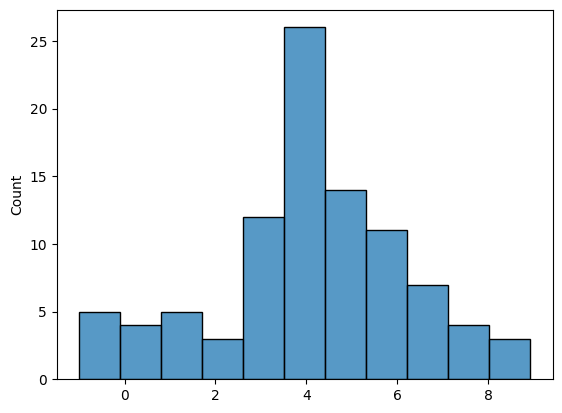

In [12]:
sns.histplot(inter_variance_dict['wpli2'])

In [16]:
#Homogeneity of variance testing
stats.levene(inter_variance_dict['coh'], inter_variance_dict['ciplv'], inter_variance_dict['wpli2'], inter_variance_dict['imcoh'])

LeveneResult(statistic=99.80369507414835, pvalue=2.58649314575522e-44)

In [ ]:
#COMPARE VARIANCES AMONG METHODS
#BOOTSTRAP T STATISTIC

In [17]:
comparison_pairs = [('coh','ciplv'), ('coh','imcoh'), ('coh','wpli2'), ('ciplv','imcoh'),('ciplv','wpli2'),('imcoh','wpli2')]

In [18]:
p_vals_overall = []

for variance_dict in [inter_variance_dict, intra_variance_dict]:

    p_val_dict = {}

    for pair in comparison_pairs:
        method1 = pair[0]
        method2 = pair[1]
    
        sample_size1 = len(variance_dict[method1])
        sample_size2 = len(variance_dict[method2])
        total_sample_size = sample_size1 + sample_size2
    
        mean1 = np.mean(variance_dict[method1])
        mean2 = np.mean(variance_dict[method2])
        
        sd1 = np.std(variance_dict[method1])
        sd2 = np.std(variance_dict[method2])
        
        n1 = len(variance_dict[method1])
        n2 = len(variance_dict[method2])
        
        pooled_sd = np.sqrt(((n1-1)*(sd1**2) + (n2-1)*(sd2**2))/(n1 + n2 - 2))
        
        t_orig = (mean1 - mean2)/(pooled_sd * np.sqrt((1/n1) + (1/n2)))
    
        pooled_sample = variance_dict[method1] + variance_dict[method2]
    
        bootstrap_sample1 = []
        bootstrap_sample2 = []
        
        for i in range(1000):
            sample1 = []
            sample2 = []
            index1 = np.random.choice(range(0,total_sample_size),sample_size1)
            index2 = np.random.choice(range(0,total_sample_size),sample_size2)
            sample1 = np.array(pooled_sample)[index1]
            sample2 = np.array(pooled_sample)[index2]
            bootstrap_sample1.append(sample1)
            bootstrap_sample2.append(sample2)

        bootstrap_t_stats = []
        for i in range(1000):
            mean1 = np.mean(bootstrap_sample1[i])
            mean2 = np.mean(bootstrap_sample2[i])
            
            sd1 = np.std(bootstrap_sample1[i])
            sd2 = np.std(bootstrap_sample2[i])
            
            n1 = len(bootstrap_sample1[i])
            n2 = len(bootstrap_sample2[i])
            
            pooled_sd = np.sqrt(((n1-1)*(sd1**2) + (n2-1)*(sd2**2))/(n1 + n2 - 2))
            
            t = (mean1 - mean2)/(pooled_sd * np.sqrt((1/n1) + (1/n2)))
        
            bootstrap_t_stats.append(t)
        
        count = 0
        for t in bootstrap_t_stats:
            if t > t_orig:
                count += 1
        
        p_val = count/1000
        
        p_val_dict[pair] = p_val
        
    p_vals_overall.append(p_val_dict)
        


In [20]:
p_vals_overall

[{('coh', 'ciplv'): 0.0,
  ('coh', 'imcoh'): 0.573,
  ('coh', 'wpli2'): 1.0,
  ('ciplv', 'imcoh'): 0.59,
  ('ciplv', 'wpli2'): 1.0,
  ('imcoh', 'wpli2'): 0.904},
 {('coh', 'ciplv'): 0.049,
  ('coh', 'imcoh'): 0.224,
  ('coh', 'wpli2'): 1.0,
  ('ciplv', 'imcoh'): 0.218,
  ('ciplv', 'wpli2'): 1.0,
  ('imcoh', 'wpli2'): 0.964}]

In [ ]:
#EXAMINING DISTRIBUTIONS TO UNDERSTAND SIGNIFICANCE

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Count'>

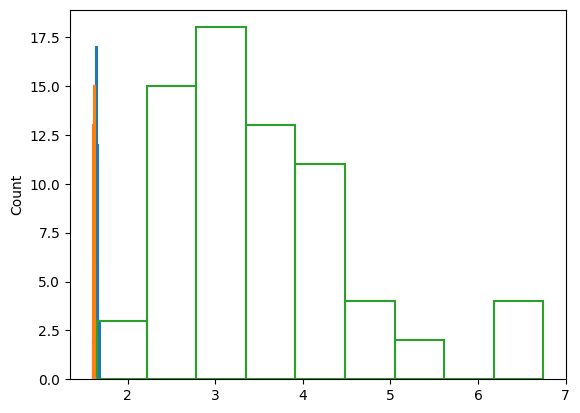

In [112]:
sns.histplot(inter_variance_dict['coh'], fill=False)
sns.histplot(inter_variance_dict['ciplv'],fill=False)
#sns.histplot(intra_variance_dict['imcoh'], fill=False)
sns.histplot(intra_variance_dict['wpli2'], fill=False)